In [15]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [7]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "MI_264_5k_fully"
    npy_file_name_aniso = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The MI_264_5k_fully data size is: (51, 264, 264, 264)
READING DATA DONE
The MI_264_5k_fully energy data size is: (51, 264, 264, 264)
READING ENERGY DATA DONE


In [25]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 5000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/T_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/T_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix.item())
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    
                    if pair_id not in curvature_matrix: continue
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

  0%|          | 0/51 [00:00<?, ?it/s]

Finish curvature calculation
Finish TJ extraction


  2%|▏         | 1/51 [12:13<10:11:14, 733.49s/it]

Current GBs len at 0 steps: 4058
Finish curvature calculation
Finish TJ extraction


  4%|▍         | 2/51 [31:41<13:27:46, 989.11s/it]

Current GBs len at 1 steps: 1892
Finish curvature calculation
Finish TJ extraction


  6%|▌         | 3/51 [51:47<14:30:31, 1088.15s/it]

Current GBs len at 2 steps: 2295
Finish curvature calculation
Finish TJ extraction


  8%|▊         | 4/51 [1:13:07<15:11:39, 1163.83s/it]

Current GBs len at 3 steps: 2754
Finish curvature calculation
Finish TJ extraction


 10%|▉         | 5/51 [1:36:36<16:00:03, 1252.25s/it]

Current GBs len at 4 steps: 3125
Finish curvature calculation
Finish TJ extraction


 12%|█▏        | 6/51 [2:01:29<16:40:34, 1334.11s/it]

Current GBs len at 5 steps: 3295
Finish curvature calculation
Finish TJ extraction


 14%|█▎        | 7/51 [2:27:32<17:13:10, 1408.87s/it]

Current GBs len at 6 steps: 3360
Finish curvature calculation
Finish TJ extraction


 16%|█▌        | 8/51 [2:54:44<17:40:34, 1479.87s/it]

Current GBs len at 7 steps: 3397
Finish curvature calculation
Finish TJ extraction


 18%|█▊        | 9/51 [3:23:03<18:03:59, 1548.55s/it]

Current GBs len at 8 steps: 3288
Finish curvature calculation
Finish TJ extraction


 20%|█▉        | 10/51 [3:52:16<18:21:11, 1611.50s/it]

Current GBs len at 9 steps: 3262
Finish curvature calculation
Finish TJ extraction


 22%|██▏       | 11/51 [4:22:30<18:35:47, 1673.69s/it]

Current GBs len at 10 steps: 3173
Finish curvature calculation
Finish TJ extraction


 24%|██▎       | 12/51 [4:53:52<18:49:02, 1736.99s/it]

Current GBs len at 11 steps: 3083
Finish curvature calculation
Finish TJ extraction


 25%|██▌       | 13/51 [5:25:53<18:55:27, 1792.84s/it]

Current GBs len at 12 steps: 2985
Finish curvature calculation
Finish TJ extraction


 27%|██▋       | 14/51 [5:58:39<18:57:45, 1845.02s/it]

Current GBs len at 13 steps: 2869
Finish curvature calculation
Finish TJ extraction


 29%|██▉       | 15/51 [6:32:08<18:56:35, 1894.32s/it]

Current GBs len at 14 steps: 2710
Finish curvature calculation
Finish TJ extraction


 31%|███▏      | 16/51 [7:06:09<18:50:46, 1938.47s/it]

Current GBs len at 15 steps: 2611
Finish curvature calculation
Finish TJ extraction
Current GBs len at 16 steps: 2520


 33%|███▎      | 17/51 [7:41:08<18:45:50, 1986.78s/it]

Finish curvature calculation
Finish TJ extraction


 35%|███▌      | 18/51 [8:16:37<18:36:12, 2029.46s/it]

Current GBs len at 17 steps: 2421
Finish curvature calculation
Finish TJ extraction


 37%|███▋      | 19/51 [8:53:04<18:27:36, 2076.77s/it]

Current GBs len at 18 steps: 2265
Finish curvature calculation
Finish TJ extraction


 39%|███▉      | 20/51 [9:30:17<18:17:20, 2123.87s/it]

Current GBs len at 19 steps: 2180
Finish curvature calculation
Finish TJ extraction


 41%|████      | 21/51 [10:07:59<18:02:41, 2165.38s/it]

Current GBs len at 20 steps: 2101
Finish curvature calculation
Finish TJ extraction


 43%|████▎     | 22/51 [10:46:14<17:45:22, 2204.23s/it]

Current GBs len at 21 steps: 2014
Finish curvature calculation
Finish TJ extraction


 45%|████▌     | 23/51 [11:25:16<17:27:58, 2245.67s/it]

Current GBs len at 22 steps: 1894
Finish curvature calculation
Finish TJ extraction


 47%|████▋     | 24/51 [12:04:48<17:07:35, 2283.53s/it]

Current GBs len at 23 steps: 1824
Finish curvature calculation
Finish TJ extraction


 49%|████▉     | 25/51 [12:44:59<16:46:01, 2321.59s/it]

Current GBs len at 24 steps: 1756
Finish curvature calculation
Finish TJ extraction


 51%|█████     | 26/51 [13:25:42<16:22:31, 2358.06s/it]

Current GBs len at 25 steps: 1663
Finish curvature calculation
Finish TJ extraction


 53%|█████▎    | 27/51 [14:07:12<15:59:07, 2397.82s/it]

Current GBs len at 26 steps: 1558
Finish curvature calculation
Finish TJ extraction


 55%|█████▍    | 28/51 [14:49:07<15:32:33, 2432.75s/it]

Current GBs len at 27 steps: 1519
Finish curvature calculation
Finish TJ extraction


 57%|█████▋    | 29/51 [15:31:57<15:07:07, 2473.99s/it]

Current GBs len at 28 steps: 1464
Finish curvature calculation
Finish TJ extraction


 59%|█████▉    | 30/51 [16:14:48<14:36:06, 2503.17s/it]

Current GBs len at 29 steps: 1411
Finish curvature calculation
Finish TJ extraction


 61%|██████    | 31/51 [16:58:27<14:05:59, 2537.96s/it]

Current GBs len at 30 steps: 1359
Finish curvature calculation
Finish TJ extraction


 63%|██████▎   | 32/51 [17:42:37<13:34:16, 2571.40s/it]

Current GBs len at 31 steps: 1300
Finish curvature calculation
Finish TJ extraction


 65%|██████▍   | 33/51 [18:27:46<13:03:51, 2612.84s/it]

Current GBs len at 32 steps: 1240
Finish curvature calculation
Finish TJ extraction


 67%|██████▋   | 34/51 [19:13:17<12:30:21, 2648.34s/it]

Current GBs len at 33 steps: 1170
Finish curvature calculation
Finish TJ extraction


 69%|██████▊   | 35/51 [19:59:11<11:54:40, 2680.05s/it]

Current GBs len at 34 steps: 1125
Finish curvature calculation
Finish TJ extraction


 71%|███████   | 36/51 [20:45:17<11:16:27, 2705.82s/it]

Current GBs len at 35 steps: 1069
Finish curvature calculation
Finish TJ extraction


 73%|███████▎  | 37/51 [21:31:55<10:37:46, 2733.33s/it]

Current GBs len at 36 steps: 1038
Finish curvature calculation
Finish TJ extraction


 75%|███████▍  | 38/51 [22:18:54<9:57:47, 2759.03s/it] 

Current GBs len at 37 steps: 998
Finish curvature calculation
Finish TJ extraction


 76%|███████▋  | 39/51 [23:06:03<9:16:01, 2780.11s/it]

Current GBs len at 38 steps: 963
Finish curvature calculation
Finish TJ extraction


 78%|███████▊  | 40/51 [23:53:45<8:34:10, 2804.62s/it]

Current GBs len at 39 steps: 943
Finish curvature calculation
Finish TJ extraction


 80%|████████  | 41/51 [24:41:51<7:51:28, 2828.90s/it]

Current GBs len at 40 steps: 927
Finish curvature calculation
Finish TJ extraction


 82%|████████▏ | 42/51 [25:29:42<7:06:13, 2841.53s/it]

Current GBs len at 41 steps: 914
Finish curvature calculation
Finish TJ extraction


 84%|████████▍ | 43/51 [26:17:03<6:18:51, 2841.45s/it]

Current GBs len at 42 steps: 892
Finish curvature calculation
Finish TJ extraction


 86%|████████▋ | 44/51 [27:04:30<5:31:42, 2843.26s/it]

Current GBs len at 43 steps: 883
Finish curvature calculation
Finish TJ extraction


 88%|████████▊ | 45/51 [27:51:59<4:44:28, 2844.76s/it]

Current GBs len at 44 steps: 867
Finish curvature calculation
Finish TJ extraction


 90%|█████████ | 46/51 [28:39:54<3:57:49, 2853.92s/it]

Current GBs len at 45 steps: 850
Finish curvature calculation
Finish TJ extraction


 92%|█████████▏| 47/51 [29:27:15<3:10:00, 2850.02s/it]

Current GBs len at 46 steps: 835
Finish curvature calculation
Finish TJ extraction


 94%|█████████▍| 48/51 [30:15:26<2:23:07, 2862.33s/it]

Current GBs len at 47 steps: 814
Finish curvature calculation
Finish TJ extraction


 96%|█████████▌| 49/51 [31:04:02<1:35:57, 2878.60s/it]

Current GBs len at 48 steps: 788
Finish curvature calculation
Finish TJ extraction


 98%|█████████▊| 50/51 [31:53:12<48:19, 2899.77s/it]  

Current GBs len at 49 steps: 767
Finish curvature calculation
Finish TJ extraction


100%|██████████| 51/51 [32:42:19<00:00, 2308.62s/it]

Current GBs len at 50 steps: 753


In [26]:
pair_id_pair

[1409, 3669]

In [27]:
    # GB Energy information
    step_num=51
    grain_nums = 5000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:00<00:00, 159.96it/s]


In [28]:
    time_interval = 2
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < 0.038: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < 0.038: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 4058/4058 [00:00<00:00, 1025577.59it/s]


finish 0 with num of GBs 0, and collected num of GBs 0


100%|██████████| 1892/1892 [00:44<00:00, 42.44it/s]


finish 1 with num of GBs 576, and collected num of GBs 384


100%|██████████| 2295/2295 [01:01<00:00, 37.29it/s]


finish 2 with num of GBs 798, and collected num of GBs 823


100%|██████████| 2754/2754 [01:10<00:00, 39.31it/s]


finish 3 with num of GBs 907, and collected num of GBs 1262


100%|██████████| 3125/3125 [01:23<00:00, 37.28it/s]


finish 4 with num of GBs 1086, and collected num of GBs 1741


100%|██████████| 3295/3295 [01:23<00:00, 39.57it/s]


finish 5 with num of GBs 1079, and collected num of GBs 2157


100%|██████████| 3360/3360 [01:25<00:00, 39.18it/s]


finish 6 with num of GBs 1110, and collected num of GBs 2561


100%|██████████| 3397/3397 [01:24<00:00, 40.44it/s]


finish 7 with num of GBs 1071, and collected num of GBs 2913


100%|██████████| 3288/3288 [01:24<00:00, 38.81it/s]


finish 8 with num of GBs 1068, and collected num of GBs 3237


100%|██████████| 3262/3262 [01:32<00:00, 35.08it/s]


finish 9 with num of GBs 1024, and collected num of GBs 3536


100%|██████████| 3173/3173 [01:46<00:00, 29.88it/s]


finish 10 with num of GBs 1043, and collected num of GBs 3791


100%|██████████| 3083/3083 [01:38<00:00, 31.15it/s]


finish 11 with num of GBs 970, and collected num of GBs 4053


100%|██████████| 2985/2985 [01:31<00:00, 32.48it/s]


finish 12 with num of GBs 899, and collected num of GBs 4250


100%|██████████| 2869/2869 [01:24<00:00, 33.96it/s]


finish 13 with num of GBs 833, and collected num of GBs 4422


100%|██████████| 2710/2710 [01:21<00:00, 33.23it/s]


finish 14 with num of GBs 800, and collected num of GBs 4585


100%|██████████| 2611/2611 [01:12<00:00, 36.01it/s]


finish 15 with num of GBs 711, and collected num of GBs 4731


100%|██████████| 2520/2520 [01:10<00:00, 35.63it/s]


finish 16 with num of GBs 693, and collected num of GBs 4862


100%|██████████| 2421/2421 [01:04<00:00, 37.26it/s]


finish 17 with num of GBs 638, and collected num of GBs 4993


100%|██████████| 2265/2265 [01:04<00:00, 35.11it/s]


finish 18 with num of GBs 632, and collected num of GBs 5110


100%|██████████| 2180/2180 [01:04<00:00, 33.97it/s]


finish 19 with num of GBs 629, and collected num of GBs 5218


100%|██████████| 2101/2101 [00:56<00:00, 37.14it/s]


finish 20 with num of GBs 555, and collected num of GBs 5317


100%|██████████| 2014/2014 [00:49<00:00, 41.03it/s] 


finish 21 with num of GBs 482, and collected num of GBs 5388


100%|██████████| 1894/1894 [00:49<00:00, 38.06it/s]


finish 22 with num of GBs 488, and collected num of GBs 5445


100%|██████████| 1824/1824 [00:44<00:00, 40.78it/s]


finish 23 with num of GBs 439, and collected num of GBs 5514


100%|██████████| 1756/1756 [00:43<00:00, 40.22it/s] 


finish 24 with num of GBs 428, and collected num of GBs 5587


100%|██████████| 1663/1663 [00:40<00:00, 40.56it/s]


finish 25 with num of GBs 403, and collected num of GBs 5639


100%|██████████| 1558/1558 [00:37<00:00, 41.39it/s]


finish 26 with num of GBs 370, and collected num of GBs 5701


100%|██████████| 1519/1519 [00:34<00:00, 44.14it/s]


finish 27 with num of GBs 338, and collected num of GBs 5744


100%|██████████| 1464/1464 [00:33<00:00, 44.13it/s]


finish 28 with num of GBs 326, and collected num of GBs 5795


100%|██████████| 1411/1411 [00:33<00:00, 42.62it/s]


finish 29 with num of GBs 332, and collected num of GBs 5839


100%|██████████| 1359/1359 [00:30<00:00, 44.84it/s]


finish 30 with num of GBs 304, and collected num of GBs 5875


100%|██████████| 1300/1300 [00:27<00:00, 47.94it/s]


finish 31 with num of GBs 272, and collected num of GBs 5906


100%|██████████| 1240/1240 [00:25<00:00, 48.96it/s]


finish 32 with num of GBs 254, and collected num of GBs 5937


100%|██████████| 1170/1170 [00:23<00:00, 50.57it/s]


finish 33 with num of GBs 232, and collected num of GBs 5964


100%|██████████| 1125/1125 [00:21<00:00, 52.22it/s]


finish 34 with num of GBs 216, and collected num of GBs 5990


100%|██████████| 1069/1069 [00:22<00:00, 47.30it/s]


finish 35 with num of GBs 227, and collected num of GBs 6015


100%|██████████| 1038/1038 [00:19<00:00, 51.99it/s]


finish 36 with num of GBs 200, and collected num of GBs 6040


100%|██████████| 998/998 [00:18<00:00, 52.58it/s]


finish 37 with num of GBs 190, and collected num of GBs 6068


100%|██████████| 963/963 [00:18<00:00, 53.34it/s] 


finish 38 with num of GBs 181, and collected num of GBs 6092


100%|██████████| 943/943 [00:17<00:00, 53.47it/s]


finish 39 with num of GBs 177, and collected num of GBs 6115


100%|██████████| 927/927 [00:15<00:00, 60.44it/s] 


finish 40 with num of GBs 154, and collected num of GBs 6131


100%|██████████| 914/914 [00:16<00:00, 55.47it/s]


finish 41 with num of GBs 165, and collected num of GBs 6151


100%|██████████| 892/892 [00:14<00:00, 63.38it/s] 


finish 42 with num of GBs 141, and collected num of GBs 6165


100%|██████████| 883/883 [00:16<00:00, 53.98it/s]


finish 43 with num of GBs 164, and collected num of GBs 6187


100%|██████████| 867/867 [00:16<00:00, 53.63it/s]


finish 44 with num of GBs 162, and collected num of GBs 6204


100%|██████████| 850/850 [00:16<00:00, 51.96it/s]


finish 45 with num of GBs 164, and collected num of GBs 6218


100%|██████████| 835/835 [00:15<00:00, 55.45it/s] 


finish 46 with num of GBs 151, and collected num of GBs 6232


100%|██████████| 814/814 [00:14<00:00, 57.06it/s] 


finish 47 with num of GBs 143, and collected num of GBs 6246


100%|██████████| 788/788 [00:13<00:00, 58.05it/s] 


finish 48 with num of GBs 136, and collected num of GBs 6246


100%|██████████| 767/767 [00:13<00:00, 56.65it/s]


finish 49 with num of GBs 136, and collected num of GBs 6246


100%|██████████| 814/814 [00:10<00:00, 80.84it/s] 


In [29]:
len(GB_id_focus_copy)

6246

In [30]:
    time_interval = 2
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < 0.038: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 767/767 [00:00<00:00, 828491.16it/s]


In [31]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 3233
The ratio of anti-curvature GBs during whole simulations is 25.100931677018636% in 12880 GBs
dict_values([6, 2, 5, 3, 2, 2, 5, 3, 2, 5, 2, 3, 3, 3, 2, 2, 3, 13, 3, 2, 3, 2, 4, 2, 2, 2, 2, 2, 5, 2, 7, 2, 2, 3, 7, 2, 2, 2, 6, 2, 2, 2, 5, 2, 3, 3, 2, 2, 3, 6, 3, 2, 2, 5, 6, 2, 3, 2, 4, 6, 3, 4, 2, 3, 2, 3, 3, 3, 2, 9, 2, 3, 5, 2, 2, 3, 3, 2, 2, 2, 4, 2, 2, 6, 2, 2, 3, 2, 3, 2, 2, 2, 3, 4, 6, 2, 2, 2, 5, 2, 3, 2, 4, 3, 2, 5, 2, 4, 2, 3, 2, 3, 2, 4, 2, 3, 2, 3, 3, 2, 2, 9, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 4, 2, 3, 2, 2, 3, 2, 2, 15, 2, 3, 2, 5, 2, 4, 4, 3, 2, 3, 2, 2, 2, 2, 3, 5, 2, 4, 2, 2, 7, 2, 2, 2, 7, 4, 2, 5, 2, 2, 2, 2, 2, 3, 4, 5, 2, 8, 8, 2, 2, 2, 2, 6, 9, 2, 4, 6, 2, 2, 10, 2, 2, 2, 4, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 6, 2, 5, 2, 6, 3, 2, 2, 8, 3, 13, 2, 2, 2, 2, 5, 4, 2, 3, 2, 6, 4, 2, 3, 2, 3, 5, 2, 2, 2, 5, 2, 5, 2, 6, 2, 2, 2, 5, 6, 6, 3, 2, 2, 2, 2, 10, 2, 2, 3, 5, 2, 2, 4, 2, 3, 7, 2

In [32]:
len(GB_list_velocity_list)

50

<Figure size 432x288 with 0 Axes>

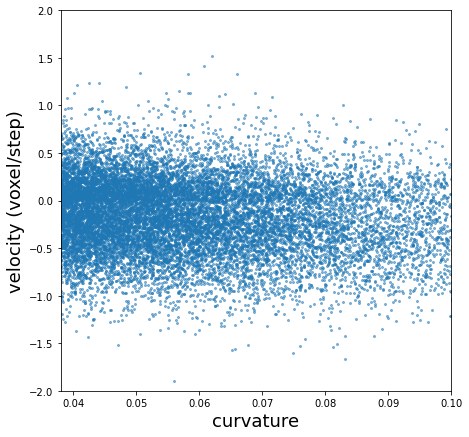

<Figure size 432x288 with 0 Axes>

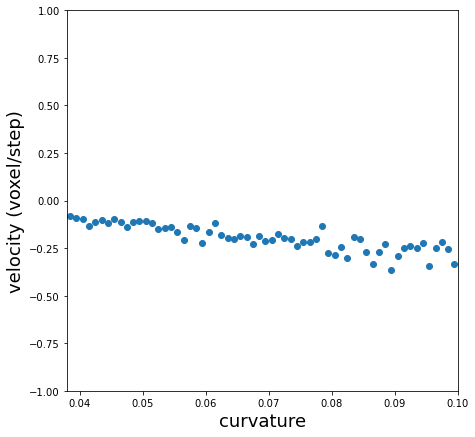

In [33]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d_mc0.038.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(curvature_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.038,0.1])
    plt.ylim([-2.0,2.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin_mc0.038.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.038,0.1])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.22045933333333334
0.16255125
0.212243
0.2037036111111111
0.2015695
0.2148565
0.076164
0.0
0.2094715
0.0
0.0
0.2042799319047619
0.0
0.0
0.154816
0.21808933333333333
0.156851
0.171595
0.22580698333333332
0.17410889999999998
0.166955875
0.0
0.10740033333333333
0.2330852777777778
0.21714333910533912
0.24636875
0.172919
0.241911
0.23048883766233766
0.0
0.22954466666666665
0.23841652884615386
0.0
0.24536826315789473
0.21381166666666665
0.0
0.8505309046579449


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

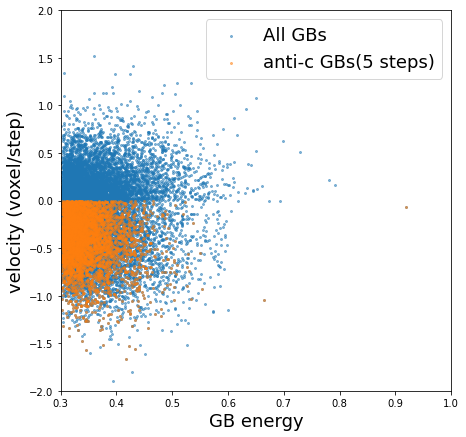

<Figure size 432x288 with 0 Axes>

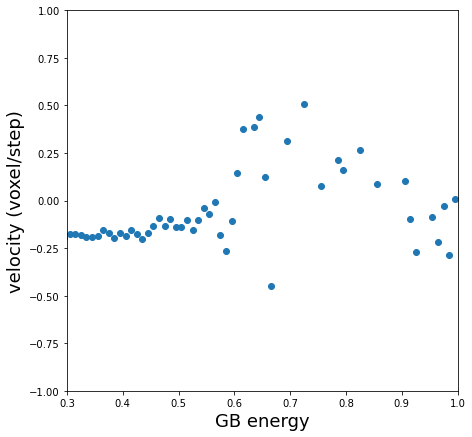

<Figure size 432x288 with 0 Axes>

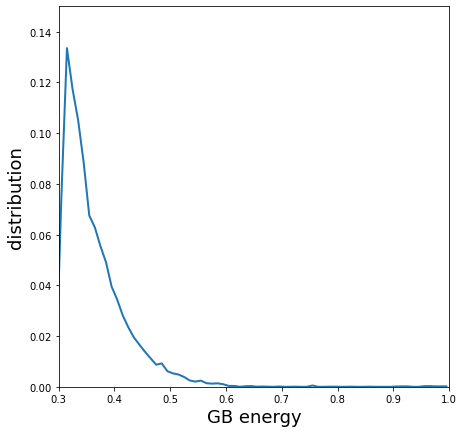

<Figure size 432x288 with 0 Axes>

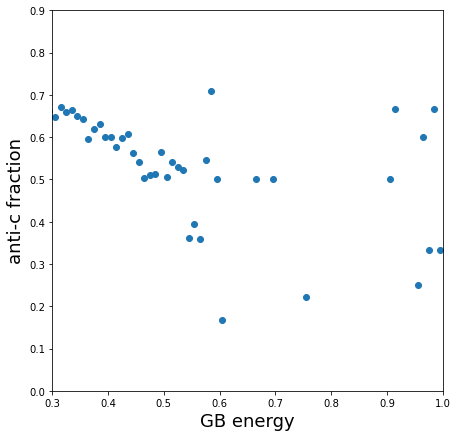

<Figure size 432x288 with 0 Axes>

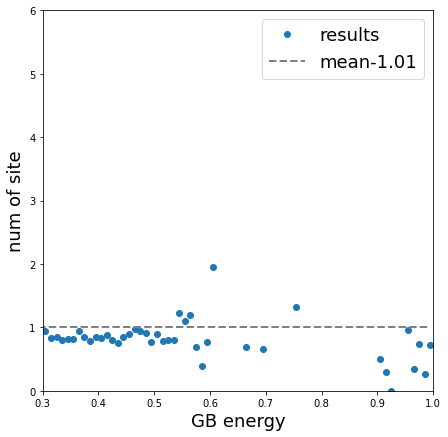

In [35]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d_mc0.038.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-2,2])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin_mc0.038.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.9])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,6])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/3D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        x_lim = [0.0,0.1]
        bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
        curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>x_lim[1]: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/3D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')